In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, SMOTENC

Categorical is ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']
Numerical is ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']


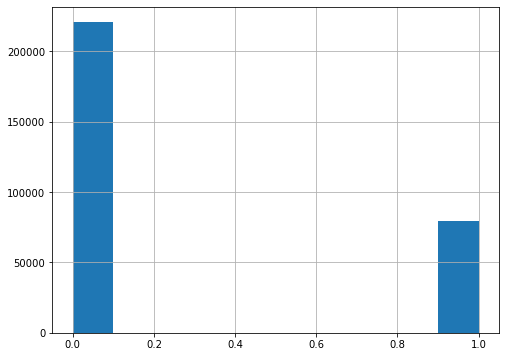

In [2]:
## Very very basic data ingest

ds_tr = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')

fig = plt.subplots(figsize=(8,6))
ds_tr['target'].hist()

if ds_tr.isnull().sum().sum() != 0:
    print('******\n There might be NULL error! \n******')

id = ds_tr['id']
target = ds_tr['target']
ds_tr = ds_tr.drop(columns=['id', 'target'], axis=1)
ds_tr.head()
cat_col = []
num_col = []
for col in ds_tr.columns:
    if np.dtype(ds_tr[col]) == 'object':
        cat_col.append(col)
    else:
        num_col.append(col)

print(f'Categorical is {cat_col}')
print(f'Numerical is {num_col}')

In [3]:
## Visualize dataset
# In categorical, use histogram
'''
fig, axes = plt.subplots(5,4, figsize=(20,10))
for i, cat in enumerate(cat_col):
    row = int(i/4)
    col = int(i%4)
    axes[row, col].set_title(cat)
    plt.tight_layout()
    ds_tr[cat].hist(ax=axes[row, col])

# In numerical, use scatter
fig, axes = plt.subplots(3,4, figsize=(20,10))
for i, num in enumerate(num_col):
    row = int(i/4)
    col = int(i%4)
    axes[row, col].set_title(num)
    plt.tight_layout()
    ds_tr[num].plot(ax=axes[row, col])
'''

'\nfig, axes = plt.subplots(5,4, figsize=(20,10))\nfor i, cat in enumerate(cat_col):\n    row = int(i/4)\n    col = int(i%4)\n    axes[row, col].set_title(cat)\n    plt.tight_layout()\n    ds_tr[cat].hist(ax=axes[row, col])\n\n# In numerical, use scatter\nfig, axes = plt.subplots(3,4, figsize=(20,10))\nfor i, num in enumerate(num_col):\n    row = int(i/4)\n    col = int(i%4)\n    axes[row, col].set_title(num)\n    plt.tight_layout()\n    ds_tr[num].plot(ax=axes[row, col])\n'

### Too many bins at ['cat5', 'cat7', 'cat8', 'cat10']
>cat5 has 84 categorical value.  
cat7 has 51 categorical value.  
cat8 has 61 categorical value.  
cat10 has 299 categorical value.  

In [4]:
toomany_col = ['cat5', 'cat7', 'cat8', 'cat10']
for x in toomany_col:
    print(f'{x} has {ds_tr.loc[:,x].value_counts().count()} categorical value.')

cat5 has 84 categorical value.
cat7 has 51 categorical value.
cat8 has 61 categorical value.
cat10 has 299 categorical value.


# SMOTE 
To resolve imbalanced data, try [SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html).

In [5]:
from sklearn.preprocessing import LabelEncoder

features = cat_col + num_col

X = ds_tr.loc[:,features]
y = target
print(f'Orignal X size = {X.size}')

cat_indices = np.arange(0, len(cat_col),1)
sm = SMOTENC(categorical_features=cat_indices, k_neighbors=10, n_jobs=-1, random_state=42)
X, y = sm.fit_resample(X,y)
print(f'SMOTED X size = {X.size}')

## If CatBoost, don't feature engineering at here!! Specify categorical columns in CatBoost!!
X = pd.get_dummies(X,columns=cat_col, drop_first=True)

Orignal X size = 9000000
SMOTED X size = 13232340


# Lightgbm Classification

* 2021/3/3
> {'lambda_l1': 0.05257926843321973, 'lambda_l2': 3.3665051868901688e-06, 'num_leaves': 256, 'feature_fraction': 0.5340551354973648, 'bagging_fraction': 0.9375929208450426, 'bagging_freq': 3, 'min_child_samples': 21, 'learning_rage': 0.009708807177251682}


In [12]:
## LightGBM Classification
best_param = {'lambda_l1': 0.05257926843321973, 'lambda_l2': 3.3665051868901688e-06, 'num_leaves': 256, 'feature_fraction': 0.5340551354973648, 'bagging_fraction': 0.9375929208450426, 'bagging_freq': 3, 'min_child_samples': 21, 'learning_rage': 0.009708807177251682}

import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

'''
def objective(trial):
    params = {
            'objective': 'binary',
            'metric': 'auc',
            'n_estimators': 1000,
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'learning_rate': trial.suggest_loguniform('learning_rage', 1e-6, 1e-2)
        }
    
    lgb_classifier = lgb.LGBMClassifier(**params)
    lgb_classifier.fit(X=X_tr, y=y_tr, eval_set=[(X_te, y_te)],eval_metric='auc', 
                       early_stopping_rounds=10,verbose=False)
    y_pred = lgb_classifier.predict_proba(X_te, num_iteration=lgb_classifier.best_iteration_)[:,1]
    
    return 1 - roc_auc_score(y_te, y_pred)
    
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_test = lgb.Dataset(X_te, y_te)

study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=-1)
lgb_best = study.best_params
print(lgb_best)
'''

"\ndef objective(trial):\n    params = {\n            'objective': 'binary',\n            'metric': 'auc',\n            'n_estimators': 1000,\n            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),\n            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),\n            'num_leaves': trial.suggest_int('num_leaves', 2, 256),\n            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),\n            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),\n            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),\n            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),\n            'learning_rate': trial.suggest_loguniform('learning_rage', 1e-6, 1e-2)\n        }\n    \n    lgb_classifier = lgb.LGBMClassifier(**params)\n    lgb_classifier.fit(X=X_tr, y=y_tr, eval_set=[(X_te, y_te)],eval_metric='auc', \n                       early_stopping_rounds=10,verbose=False)\n    y_pred 

# CatBoost Classification
* category columnsをfit時に選択すると、時間むっちゃかかる
* SMOTENC + CatBoostでは、 "Best is trial 45 with value: 0.13424544780540504." の程度

In [7]:
## CatBoost Classification
'''
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        #'iterations' : trial.suggest_int('iterations', 50, 3000),
        'iterations' : 1000,
        'loss_function': 'CrossEntropy',
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-6, 0.1),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    # 学習
    model = CatBoostClassifier(**params)
    
    model.fit(X=X_tr, y=y_tr, eval_set=[(X_te, y_te)], use_best_model=True, early_stopping_rounds=50, verbose=False)
    y_pred = model.predict(X_te)
    
    return 1 - roc_auc_score(y_te, y_pred)
    
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=-1)
cat_best = study.best_params
print(cat_best)
'''

"\nimport optuna\nfrom catboost import CatBoostClassifier\nfrom sklearn.metrics import roc_auc_score\n\ndef objective(trial):\n    params = {\n        #'iterations' : trial.suggest_int('iterations', 50, 3000),\n        'iterations' : 1000,\n        'loss_function': 'CrossEntropy',\n        'depth' : trial.suggest_int('depth', 4, 10),                                       \n        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-6, 0.1),               \n        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       \n        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), \n        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),\n        'od_wait' :trial.suggest_int('od_wait', 10, 50)\n    }\n\n    # 学習\n    model = CatBoostClassifier(**params)\n    \n    model.fit(X=X_tr, y=y_tr, eval_set=[(X_te, y_te)], use_best_model=True, early_stopping_rounds=50, verbose=False)\n    y_pred = 

In [13]:
## Predict
predict_ds = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')
id = predict_ds['id']
predict_ds = predict_ds.drop(columns=['id'], axis=1)
predict_ds = pd.get_dummies(predict_ds, columns=cat_col, drop_first=True)

lgb_classifier = lgb.LGBMClassifier(**best_param)
lgb_classifier.fit(X=X_tr, y=y_tr, eval_set=[(X_te, y_te)],eval_metric='auc', 
                   early_stopping_rounds=10,verbose=False)
y_pred = lgb_classifier.predict_proba(predict_ds, num_iteration=lgb_classifier.best_iteration_)[:,1]

'''
predictor = CatBoostClassifier(**cat_best)
predictor.fit(X=X_tr, y=y_tr, eval_set=[(X_te, y_te)],cat_features=cat_col, 
               use_best_model=True, early_stopping_rounds=50, verbose=False)
    
y_pred = predictor(predict_ds)
'''

output = pd.DataFrame({'id': id, 'target': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

[LightGBM] [Warning] Unknown parameter: learning_rage
[LightGBM] [Warning] lambda_l1 is set=0.05257926843321973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05257926843321973
[LightGBM] [Warning] bagging_fraction is set=0.9375929208450426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9375929208450426
[LightGBM] [Warning] lambda_l2 is set=3.3665051868901688e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3665051868901688e-06
[LightGBM] [Warning] feature_fraction is set=0.5340551354973648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5340551354973648
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


ValueError: Number of features of the model must match the input. Model n_features_ is 615 and input n_features is 611 